In [17]:
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import tts
import tts.utils

# For Mayavi vizualization
%gui qt

# Rerun this cell to load changes in the ttf module
import importlib
importlib.reload(tts)
importlib.reload(tts.utils)

<module 'tts.utils' from '/home/simon/skoltech/chemoinformatics/project/tensor_to_structure/v2/tts/utils.py'>

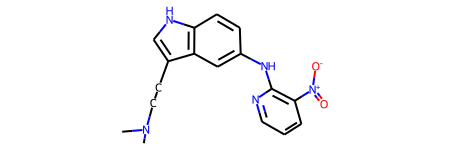

In [2]:
# Load the ligand dataset
data_supplier = Chem.SDMolSupplier('glass.sdf')
ligands = []
for i, ligand in enumerate(data_supplier):
    if i > 100:
        break
    ligands.append(ligand)
original_molecule = ligands[0]
original_molecule

In [3]:
# Let's see its content
from collections import defaultdict
counter = defaultdict(int)
for ligand in ligands[:100]:
    for atom in ligand.GetAtoms():
        counter[atom.GetSymbol()] += 1
counter

defaultdict(int,
            {'C': 2250,
             'N': 380,
             'O': 332,
             'S': 44,
             'F': 24,
             'Cl': 31,
             'Br': 6,
             'P': 1})

In [4]:
# Let's remove ligands with rare Br and P atoms
filtered_ligands = []
for ligand in ligands[:100]:
    good = True
    for atom in ligand.GetAtoms():
        if atom.GetSymbol() in ['Br', 'P']:
            good = False
            break
    if good:
        filtered_ligands.append(ligand)
ligands = filtered_ligands

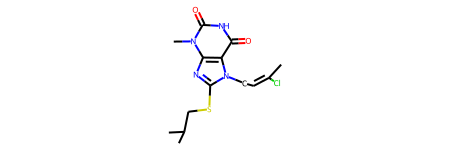

In [5]:
# Let's choose the most sofisticated ligand
top_ligand = None
max_types = 0
for ligand in ligands:
    types = set()
    for atom in ligand.GetAtoms():
        types.add(atom.GetSymbol())
    if len(types) > max_types:
        top_ligand = ligand
        max_types = len(types)
top_ligand

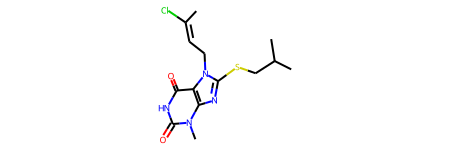

In [6]:
# And create conformer of it
top_ligand = Chem.AddHs(top_ligand)
Chem.AllChem.EmbedMolecule(top_ligand)
Chem.AllChem.UFFOptimizeMolecule(top_ligand)
top_ligand = Chem.RemoveHs(top_ligand)
top_ligand

In [7]:
# Now we will set basic parameters

# AtomDescriptor is a pair (atom_radius, set(channels))
# Create a map from atom type to its descriptor
descriptors = {
    6: tts.AtomDescriptor(1.0, {0, 1}),  # C
    7: tts.AtomDescriptor(0.9, {0, 2}),  # N
    8: tts.AtomDescriptor(0.85, {0, 3}),  # O
    9: tts.AtomDescriptor(0.8, {0, 4}),  # F
    16: tts.AtomDescriptor(1.0, {0, 5}),  # S
    17: tts.AtomDescriptor(0.9, {0, 6}),  # Cl
}

# A map from atom type to its maximal valence
maximal_valence = {
    6: 4,
    7: 3,
    8: 2,
    9: 1,
    16: 6,
    17: 1,
}

# Create an example function for bond distances.
# It takes an atom types and return maximal distance list for bonds:
# [TRIPLE, DOUBLE, SINGLE]
#
# For example, {C, C} maximal distances are [1.27, 1.44, 1.64]
# So, if the atoms are within 1.30 A, the algorithm will set DOUBLE bound.

def test_get_distances(lhs, rhs):
    # https://www.chegg.com/homework-help/using-bond-lengths-table-92-p-340-assuming-ideal-geometry-ca-chapter-10-problem-95p-solution-9780077340230-exc
    pair = set([lhs, rhs])

    if pair == set([6, 6]):  # C C
        return [1.27, 1.44, 1.64]
    elif pair == set([6, 7]):  # C N
        return [1.21, 1.37, 1.65]
    elif pair == set([6, 8]):  # C O
        return [1.18, 1.33, 1.53]
    elif pair == set([6, 9]):  # C F
        return [0, 0, 1.43]
    elif pair == set([6, 16]):  # C S
        return [0, 0, 1.91]
    elif pair == set([6, 17]):  # C Cl
        return [0, 0, 1.88]
    elif pair == set([7, 7]):  # N N
        return [1.16, 1.34, 1.56]
    elif pair == set([7, 8]):  # N O
        return [1.13, 1.32, 1.52]
    elif pair == set([7, 9]):  # N F
        return [0, 0, 1.49]
    elif pair == set([7, 16]):  # N S
        return [0, 0, 0]
    elif pair == set([7, 17]):  # N Cl
        return [0, 0, 2.0]
    elif pair == set([8, 8]):  # O O
        return [0, 1.34, 1.58]
    elif pair == set([8, 9]):  # O F
        return [0, 0, 1.52]
    elif pair == set([8, 16]):  # O S
        return [0, 0, 1.61]
    elif pair == set([8, 17]):  # O Cl
        return [0, 0, 1.74]
    elif pair == set([9, 9]):  # F F
        return [0, 0, 1.53]
    elif pair == set([9, 16]):  # F S
        return [0, 0, 1.68]
    elif pair == set([9, 17]):  # F Cl
        return [0, 0, 1.76]
    elif pair == set([16, 16]):  # S S
        return [0, 0, 2.14]
    elif pair == set([16, 17]):  # S Cl
        return [0, 0, 2.11]
    elif pair == set([17, 17]):  # Cl Cl
        return [0, 0, 2.09]
    else:
        raise RuntimeError('Unknown distances for pair ' + str(pair))

In [8]:
# Convert top ligand into Molecule object
top_ligand_mol = tts.rdkit_to_molecule(top_ligand)

# Create density tensor. I use my test_voxelizer for demonstration purpouses.
original_tensor = tts.utils.test_voxelizer(top_ligand_mol, descriptors)

Text(0.5, 0, 'Number of atoms')

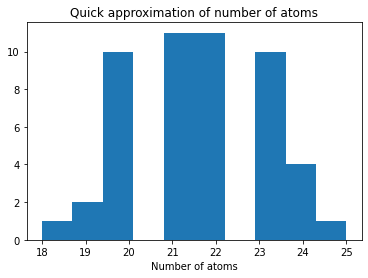

In [21]:
#! Function for fast evaluation of min and max number of atoms for a givenchannel
estimations = []
for i in range(50):
    estimations.append(tts.estimate_total_atoms(original_tensor, radius=3, epsilon=0.1))
plt.hist(estimations)
plt.title('Quick approximation of number of atoms')
plt.xlabel('Number of atoms')

In [9]:
# Let's run the fitting procedure.
# I've already chosen very precise and slow parametets for this tutorial.
# To see all parameters, run 'tts.tensor_to_structure?'
results = tts.tensor_to_structure(original_tensor,
                                  descriptors,
                                  voxel_step=0.5,
                                  min_atoms=22,
                                  max_atoms=23,
                                  trials=70,
                                  max_iter=500,
                                  n_init=5,
                                  tol=1e-6,
                                  threshold=0.1,
                                  calculate_bic=False,
                                  verbose=1)

#! Function to get 3D coordinates and atom types from 4D tensor (N atomsis input) 

Fitting 22 atoms...


In [10]:
# The function returned a dict with additional info.
# We only need molecule.
result = results[0][0]

<IPython.core.display.Javascript object>


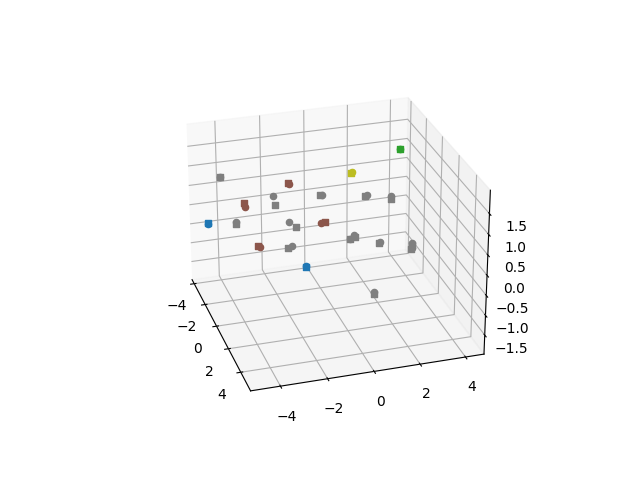

In [11]:
# Let's see how good out fit is. Squares are true coordinates and circles are the fitted atoms.
%matplotlib notebook
tts.utils.plot_coordinates(result, top_ligand_mol)

In [12]:
# The result should be very good even for such complicated molecule. If not, try to restart the fitting procedure.
# Because of stochastic nature of the algorithm, unoptimal fit can be obtained.

In [13]:
# We can access the raw coordinates:
for atom in result.atoms:
    print(atom.coordinates, atom.atom_type)

[-1.00218291 -0.26643174  0.00924319] 7
[ 4.85519368  0.19038326 -0.21322813] 6
[-1.24116962 -2.30318472  0.77702082] 6
[-2.30343243  3.35536186  0.09952856] 6
[3.55451305 2.24937864 0.34792222] 6
[-0.2200697  -1.89090902  1.31635138] 7
[-3.24831886 -0.27789951 -1.73049084] 8
[-1.92454058 -3.37948556  0.42839329] 7
[-3.76734676 -4.61312598 -0.39242967] 8
[-1.50779332  4.06790329 -0.98003319] 6
[-0.98690061  1.22037471 -0.40899757] 6
[ 2.50800225 -0.07808707  0.48556924] 6
[-3.46723296 -2.35025661 -1.10563098] 7
[-1.56745459 -4.54161797  1.34832999] 6
[-1.57513764 -1.54342614 -0.01506891] 6
[-3.17033697 -3.46500492 -0.27436131] 6
[-2.68506535 -1.11042518 -0.96435117] 6
[-3.49137453  4.18018147  0.98284809] 17
[-1.9869899   2.12074012  0.29214589] 6
[3.77322153 0.77593214 0.67909483] 6
[1.26612843 0.36824688 1.80001548] 16
[ 0.01471099 -0.52709007  0.99075202] 6


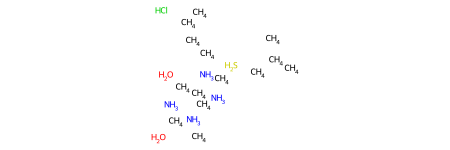

In [14]:
# ... or we can convert it to rdkit molecule
tts.molecule_to_rdkit(result)

In [15]:
# Since tensor_to_structure only obtain coordinates, let's use other function to set proper bonds
result_molecule = tts.get_bonds(result, test_get_distances, maximal_valence)
#! Function to assign the covalent bonds given the 3D coordinates and atomtypes

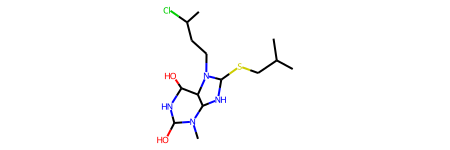

In [16]:
# Our result
result_molecule

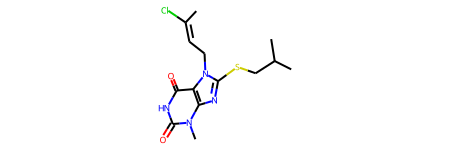

In [17]:
# Original
top_ligand

In [18]:
# Again, because of randomness, the molecules could be different. 
# Furthermore, there is no option for the benzole's bonds, so they are either SINGLE or DOUBLE.

In [19]:
# Let's find RMS for difference between true coordinates and the fitted ones.
tts.get_best_rms(result_molecule, top_ligand)

# Note, that the get_best_rms function will try to align two molecules together. 
# It should help in difficult pipelines, but in our case it can throw an error, if the generated molecule cannot be aligned.
# In this case, either select different fitting parameters, or find rms of molecule with no bond:
#     no_bond_molecule = tts.molecule_to_rdkit(result)
#     tts.get_best_rms(no_bond_molecule, top_ligand)

#! Function to compare generated 3D structure with the true 3D structure:RMSD-based; ECFP-based

0.13612451728262384

In [20]:
# Woah! It should be less than 0.5 A

In [21]:
# Let's calculate Tanimoto similiarity
tts.get_ecfp_similarity(result_molecule, top_ligand)
#! Function to compare generated 3D structure with the true 3D structure:RMSD-based; ECFP-based

[0.3050847457627119, 0.25, 0.21951219512195122]

In [22]:
# It's low, because of the benzole bonds.

In [23]:
# If you have mayavi library, you can visualize densities
# Let's do voxelization of the result (takes some time)
after_tensor = tts.utils.test_voxelizer(result, descriptors)

# And visualize it
%gui qt
tts.utils.plot_side_by_side(original_tensor, after_tensor)

In [24]:
# Run this cell to close mayavi windows
tts.utils.close_mlab()

In [25]:
# That's all! For edditional info, see doc-lines of functions.